In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import functools
import io
import itertools
import shutil
import os
import json
import subprocess
from pathlib import Path

import dotenv
from box import Box

# visualization libraries
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import seaborn as sns

# Computation & ML libraries.
import numpy as np
import pandas as pd

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc


True

In [3]:
sim_subj_ids = (
    "sim-965367",
    "sim-131924",
    "sim-121618",
    "sim-126426",
    "sim-859671",
)
results_dir = Path("scilpy_bundle_rating")

full_res_comparison_name = "full_res"
model_names = ("fenri", "fixed-net", "trilin-dwi", "fenri-pred_trilin-tract")

bundles = (
    "CC_temporal",
    "CC_u_shaped",
    "CC_ventro_striatal1",
    "CC_ventro_striatal2",
    "UF_left",
    "UF_right",
    "OR_left",
    "OR_right",
    "SLF_left",
    "SLF_right",
    "ILF_left",
    "ILF_right",
    "Cingulum_left",
    "Cingulum_right",
    "BPS_left",
    "BPS_right",
)

metrics = (
    "total_streamlines",
    "VS_ratio",
    "IS",
    "IS_ratio",
    {
        "bundle_wise": (
            "VS",
            "TP",
            "FP",
            "FN",
            "OL",
            "OR_pct_vs",
            "OR_pct_gt",
            "f1",
            "endpoints_OL",
            "endpoints_OR",
        )
    },
)
# See <https://scilpy.readthedocs.io/en/latest/scripts/scil_score_tractogram.html>
# for an explanation of these metrics.

In [4]:
# Collect the full-res comparison metrics.
full_res_comp_table = dict(
    model_name=list(),
    subj_id=list(),
    bundle=list(),
    metric_name=list(),
    value=list(),
)
table_dtypes = dict(
    model_name="string",
    subj_id="string",
    bundle="string",
    metric_name="string",
    value="Float64",
)

for subj_id in sim_subj_ids:
    subj_root_dir = results_dir / subj_id / "remove_invalid_streams"
    full_res_comp_dir = subj_root_dir / full_res_comparison_name

    for bundle in bundles:
        bundle_result_f = list(
            (full_res_comp_dir / bundle).glob(f"*{bundle}*results.json")
        )
        assert len(bundle_result_f) == 1
        bundle_result_f = bundle_result_f[0]
        with open(bundle_result_f, "rt") as f:
            result_dict = json.load(f)

        for metric in metrics:
            if isinstance(metric, dict):
                assert len(metric.keys()) == 1
                assert len(metric.values()) == 1
                sub_metrics = list(metric.values())[0]
                sub_metric_k = list(metric.keys())[0]
                result_sub_dict = result_dict[sub_metric_k][bundle]
                for sub_metric in sub_metrics:
                    score = result_sub_dict[sub_metric]
                    score = int(score) if (score == int(score)) else float(score)
                    full_res_comp_table["model_name"].append(full_res_comparison_name)
                    full_res_comp_table["subj_id"].append(str(subj_id))
                    full_res_comp_table["bundle"].append(bundle)
                    full_res_comp_table["metric_name"].append(sub_metric)
                    full_res_comp_table["value"].append(float(score))
            else:
                score = result_dict[metric]
                score = int(score) if (score == int(score)) else float(score)
                full_res_comp_table["model_name"].append(full_res_comparison_name)
                full_res_comp_table["subj_id"].append(str(subj_id))
                full_res_comp_table["bundle"].append(bundle)
                full_res_comp_table["metric_name"].append(metric)
                full_res_comp_table["value"].append(score)


full_res_comp_table = pd.DataFrame.from_dict(full_res_comp_table)
full_res_comp_table.to_csv(
    "full_res_comparison_scores.csv", index=False, float_format="%g"
)
full_res_comp_table

,model_name,subj_id,bundle,metric_name,value
0,full_res,sim-965367,CC_temporal,total_streamlines,2011.000000
1,full_res,sim-965367,CC_temporal,VS_ratio,0.044754
2,full_res,sim-965367,CC_temporal,IS,1921.000000
3,full_res,sim-965367,CC_temporal,IS_ratio,0.955246
4,full_res,sim-965367,CC_temporal,VS,90.000000
...,...,...,...,...,...
1115,full_res,sim-859671,BPS_right,OR_pct_vs,0.035925
1116,full_res,sim-859671,BPS_right,OR_pct_gt,0.014906
1117,full_res,sim-859671,BPS_right,f1,0.565423
1118,full_res,sim-859671,BPS_right,endpoints_OL,1794.000000


In [5]:
# All model scores.
results_table = dict(
    model_name=list(),
    subj_id=list(),
    bundle=list(),
    metric_name=list(),
    value=list(),
)
table_dtypes = dict(
    model_name="string",
    subj_id="string",
    bundle="string",
    metric_name="string",
    value="Float64",
)

for subj_id in sim_subj_ids:
    subj_root_dir = results_dir / subj_id / "remove_invalid_streams"

    for model in model_names:
        model_dir = subj_root_dir / model

        for bundle in bundles:
            bundle_result_f = list((model_dir / bundle).glob(f"*{bundle}*results.json"))
            assert len(bundle_result_f) == 1
            bundle_result_f = bundle_result_f[0]
            with open(bundle_result_f, "rt") as f:
                result_dict = json.load(f)

            for metric in metrics:
                if isinstance(metric, dict):
                    assert len(metric.keys()) == 1
                    assert len(metric.values()) == 1
                    sub_metrics = list(metric.values())[0]
                    sub_metric_k = list(metric.keys())[0]
                    result_sub_dict = result_dict[sub_metric_k][bundle]
                    for sub_metric in sub_metrics:
                        score = result_sub_dict[sub_metric]
                        score = int(score) if (score == int(score)) else float(score)

                        full_res_comparison = full_res_comp_table.query(
                            f"(subj_id == '{subj_id}') & "
                            f"(bundle == '{bundle}') & "
                            f"(metric_name == '{sub_metric}')"
                        )
                        assert len(full_res_comparison) == 1
                        fr_comp_score = full_res_comparison.value.to_numpy().item()
                        # Save both the original score and that score relative to the
                        # hypothetical ceiling given by the original, full-res
                        # tractography.
                        if fr_comp_score == 0:
                            score_scaled_to_fr = np.nan
                        else:
                            score_scaled_to_fr = score / fr_comp_score
                        for s, m in zip(
                            [score, score_scaled_to_fr],
                            [sub_metric, f"{sub_metric}_over_full_res_score"],
                        ):
                            results_table["model_name"].append(model)
                            results_table["subj_id"].append(str(subj_id))
                            results_table["bundle"].append(bundle)
                            results_table["metric_name"].append(m)
                            results_table["value"].append(s)
                else:
                    score = result_dict[metric]
                    score = int(score) if (score == int(score)) else float(score)
                    full_res_comparison = full_res_comp_table.query(
                        f"(subj_id == '{subj_id}') & "
                        f"(bundle == '{bundle}') & "
                        f"(metric_name == '{metric}')"
                    )
                    assert len(full_res_comparison) == 1
                    fr_comp_score = full_res_comparison.value.to_numpy().item()
                    if fr_comp_score == 0:
                        score_scaled_to_fr = np.nan
                    else:
                        score_scaled_to_fr = score / fr_comp_score

                    for s, m in zip(
                        [score, score_scaled_to_fr],
                        [metric, f"{metric}_over_full_res_score"],
                    ):
                        results_table["model_name"].append(model)
                        results_table["subj_id"].append(str(subj_id))
                        results_table["bundle"].append(bundle)
                        results_table["metric_name"].append(m)
                        results_table["value"].append(s)


results_table = pd.DataFrame.from_dict(results_table)
results_table.to_csv("model_tractography_scores.csv", index=False, float_format="%g")
results_table

,model_name,subj_id,bundle,metric_name,value
0,fenri,sim-965367,CC_temporal,total_streamlines,1895.000000
1,fenri,sim-965367,CC_temporal,total_streamlines_over_full_res_score,0.942317
2,fenri,sim-965367,CC_temporal,VS_ratio,0.055937
3,fenri,sim-965367,CC_temporal,VS_ratio_over_full_res_score,1.249874
4,fenri,sim-965367,CC_temporal,IS,1789.000000
...,...,...,...,...,...
8955,fenri-pred_trilin-tract,sim-859671,BPS_right,f1_over_full_res_score,0.824859
8956,fenri-pred_trilin-tract,sim-859671,BPS_right,endpoints_OL,1301.000000
8957,fenri-pred_trilin-tract,sim-859671,BPS_right,endpoints_OL_over_full_res_score,0.725195
8958,fenri-pred_trilin-tract,sim-859671,BPS_right,endpoints_OR,276.000000


/home/tas6hh/miniconda/envs/pitn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 900x600 with 0 Axes>

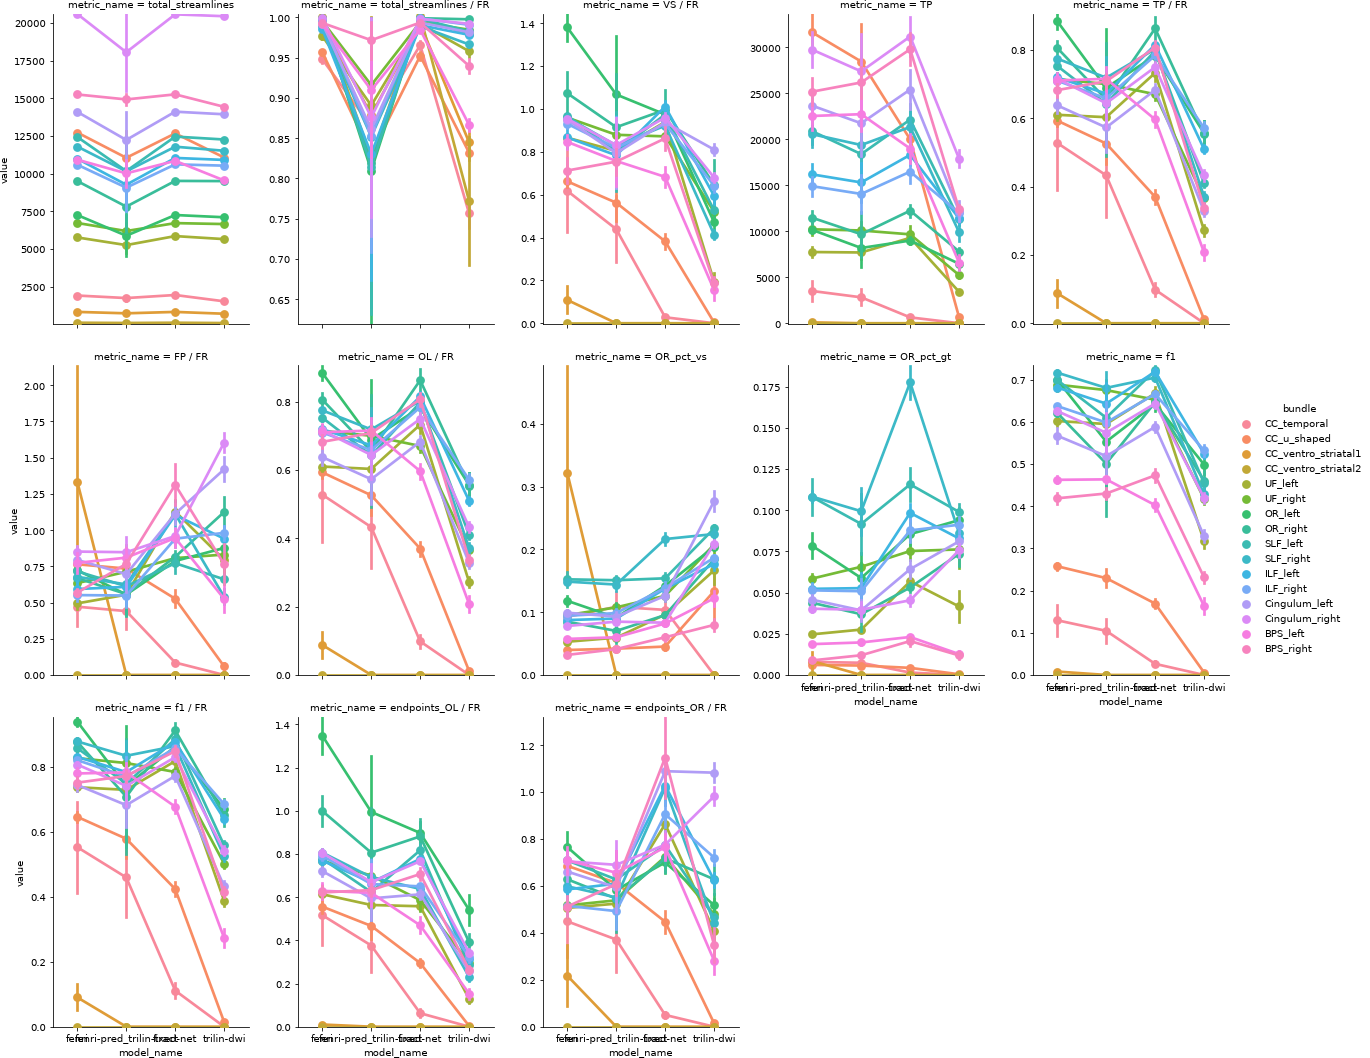

In [16]:
tract_metrics_of_interest = (
    "total_streamlines",
    "total_streamlines_over_full_res_score",
    "VS_over_full_res_score",
    "TP",
    "TP_over_full_res_score",
    "FP_over_full_res_score",
    "OL_over_full_res_score",
    "OR_pct_vs",
    "OR_pct_gt",
    "f1",
    "f1_over_full_res_score",
    "endpoints_OL_over_full_res_score",
    "endpoints_OR_over_full_res_score",
)

plot_table = results_table.copy(deep=True)
plot_table = plot_table[plot_table.metric_name.isin(tract_metrics_of_interest)]
plot_table.metric_name[
    plot_table.metric_name.map(lambda n: "_over_full_res_score" in n.casefold())
] = list(
    map(
        lambda m: m.replace("_over_full_res_score", r" / FR"),
        plot_table.metric_name.tolist(),
    )
)

plt.figure(dpi=150)
g = sns.catplot(
    plot_table,
    kind="point",
    x="model_name",
    y="value",
    hue="bundle",
    col="metric_name",
    sharex=True,
    sharey=False,
    col_wrap=5,
    aspect=0.7,
    errorbar="se",
    order=(
        "fenri",
        "fenri-pred_trilin-tract",
        "fixed-net",
        "trilin-dwi",
    ),
)
# sns.lmplot(
#     plot_table,
#     kind='strip',
#     x='model_name',
#     y='value',
#     hue='bundle',
#     col='metric_name',
#     sharex=True,
#     sharey=False,
#     col_wrap=5,
#     aspect=.7,
# )
# sns.lmplot(
#     plot_table,
#     x="model_name",
#     y="value",

# )

plt.show()